# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [51]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [52]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics = critics[critics.astype(str).ne('none').all(1)]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [53]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15534
Number of critics: 622
Number of movies:  1921


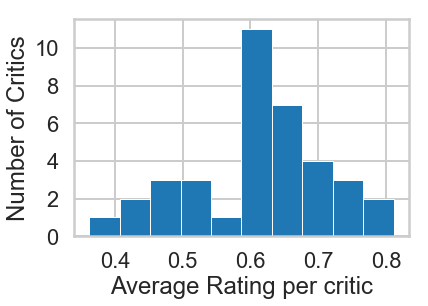

In [54]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

**Solution:**

*The most common average movie ratings per critic( whose number of reviews is greater than 100) is 0.6. The distribution looks like it is left skewed. What's interesting about the distributon is that most of the average movie ratings per critic is >0.6. The distribution seems to be smooth to the right of 0.6 and look completely scattered to the left of 0.6. This suggests the balancing act done by most of the critics by setting a base rating which is somewhere in the middle and they rarely rate below 0.6.*

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [56]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("testing accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

training accuracy:  0.9242817334486403
testing accuracy:  0.7706260971328263


*We achieved 92% accuracy in training set which is way more than the 78% accuracy score in the test set(“unseen”). Our model doesn’t generalize well from our training data to unseen data. We can’t use this classifier since this model maybe just overfitting the distribution of training data.*

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

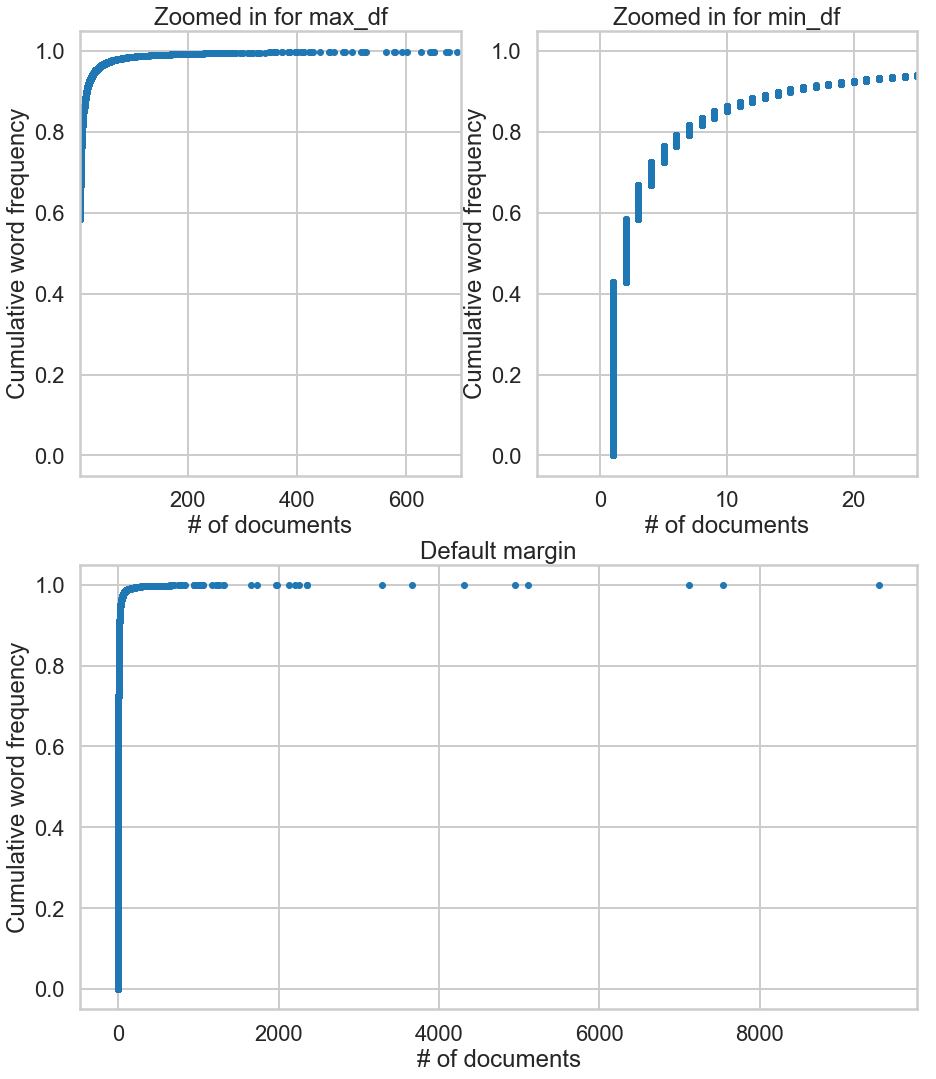

In [58]:
# Your turn.
X, y = make_xy(critics)
# Transform scipy.sparse.csc.csc_matrix to dataframe
df2 = pd.DataFrame((X>0).sum(axis=0)).T

df2.columns = ['frequency']

#defining ecdf function 
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: yThe y data of the ECDF go from 1/n to 1 in equally spaced increments. You can construct this using np.arange().
    #Remember, however, that the end value in np.arange() is not inclusive. Therefore, np.arange() will need to go from 1 to n+1.
    # Be sure to divide this by n.
    y = np.arange(1,n+1) / n

    return x, y
'''use  ecdf() function to Construct the cumulative distribution of document frequencies plots '''
x_1 , y_1 = ecdf(df2.frequency)
fig, (ax1, ax2,ax3) = plt.subplots(3, figsize = (15,18))

ax1 = plt.subplot(212)
plt.plot(x_1 , y_1, marker = ".", linestyle= 'none')
ax1.set_title('Default margin')
plt.xlabel("# of documents")
plt.ylabel('Cumulative word frequency')

ax2 = plt.subplot(221)
plt.plot(x_1 , y_1, marker = ".", linestyle= 'none')
plt.xlim(3, 700)
ax2.set_title('Zoomed in for max_df')
plt.xlabel("# of documents")
plt.ylabel('Cumulative word frequency')

ax3 = plt.subplot(222)
plt.plot(x_1 , y_1, marker = ".", linestyle= 'none')
plt.xlim(-5, 25)
ax3.set_title('Zoomed in for min_df')
plt.xlabel("# of documents")
plt.ylabel('Cumulative word frequency')
plt.show()

 *As we can see from the default margin plot above, the curve rises steeply just around 0. To set the min_df and max_df, we need to see the zoomed in version of the plots by setting axis limits. 10 documents or less in count had 85%  of words in vocabulary. Min_df  is used for removing terms that appear too infrequently., and max_df is used for removing terms that appear too frequently. The curve starts to plateau from 23 till it reaches 250.  So, I think if we set min_df = 23 and max_df = 250, that should cover  maximum% of the vocabulary.*

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [59]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [60]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [61]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), test_size = 0.3)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

**Exercise: What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?**

*Given a dataset, what we want is to maximise the likelihood of the parameters. Maximising the likelihood of the parameters would mean maximising the probability. To get to the optimim, if we iterate to maximize probability, it would require a huge memory capacity. The log of a likelihood function is easier to work with as it converts condition probability products into sums. The natural logarithm is a monotonically increasing function. Gradient methods generally work better optimizing $logp(x)$ than $p(x)$ because the gradient of $logp(x)$ is generally more well-scaled. That is, it has a size that consistently  reflects the objective function's geometry, making it easier to select an appropriate step size and get to the optimum in fewer steps.*

**Exercise: Without writing any code, what do you think would happen if you choose a value of  𝛼  that is too high?**

*$\alpha$ is a smoothing parameter, at its lowest value, there will be no smoothing, or the model will overfit the training data. If it is too high, the smoothing is going to be very high leading to lower accuracy*

**Exercise: Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.**

In [62]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs= [5,10,15,20,23,25,30,35] ## best 

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for m in min_dfs:
    for alpha in alphas:        
        vectorizer = CountVectorizer(min_df=m)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        print('alpha:',alpha,' min df:',m,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=m
print('\n','best alpha:',best_alpha,'\n','best min df:',best_min_df,' max score',maxscore)

alpha: 0.1  min df: 5  score: -926.4327425873469
alpha: 1  min df: 5  score: -615.8491365825494
alpha: 5  min df: 5  score: -699.8883106319383
alpha: 10  min df: 5  score: -900.0206405107228
alpha: 50  min df: 5  score: -1169.047247364098
alpha: 0.1  min df: 10  score: -819.3071103159785
alpha: 1  min df: 10  score: -605.2408771852749
alpha: 5  min df: 10  score: -589.1558416660517
alpha: 10  min df: 10  score: -713.0014432820822
alpha: 50  min df: 10  score: -1056.909985606153
alpha: 0.1  min df: 15  score: -745.8289117915742
alpha: 1  min df: 15  score: -598.2828279659923
alpha: 5  min df: 15  score: -564.6143394449085
alpha: 10  min df: 15  score: -636.9668957669583
alpha: 50  min df: 15  score: -974.9318388133661
alpha: 0.1  min df: 20  score: -705.9545648298697
alpha: 1  min df: 20  score: -595.8553834656803
alpha: 5  min df: 20  score: -558.9635022817906
alpha: 10  min df: 20  score: -605.1118401877229
alpha: 50  min df: 20  score: -918.8326481213662
alpha: 0.1  min df: 23  score

In [63]:
print("alpha: {}".format(best_alpha))

alpha: 5


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [64]:
vectorizer = CountVectorizer(min_df=23)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.788672
Accuracy on test data:     0.712131


In [65]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2191 2001]
 [1129 5552]]


*Assuming from the confusion matrix above, 2001 predictied turned out to be false positives ,  1129 predicted were false negatives, 2191 predicted were true positives, and 5552 predicted were true negatives. Eventhough the accuracy of this classifier is not that great, this classifier is still better than the original one since the accuracy metrics  between train and test sets are not more than 7~8% of each other which in turn helps reduce the overfitting problem.* 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [66]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.87
            american 0.86
               witty 0.85
        entertaining 0.85
               gives 0.84
         intelligent 0.84
         performance 0.83
               years 0.82
           beautiful 0.82
                 war 0.82
Bad words	     P(fresh | word)
           formulaic 0.30
             nothing 0.29
               feels 0.28
             numbers 0.26
               worst 0.26
       disappointing 0.26
               bland 0.23
                dull 0.22
                  tv 0.20
       unfortunately 0.20


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

*This method builds a review with just one word and tries to classify the review based on that one word.This method works as it associates the occurence of an individual word to the final prediction, so all the words in a sentence are considered. The probability of the each row represents how likely the movie is to be voted fresh given that the word occured in the review.*

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [67]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilience of the American dream.

Greenaway, whose mind is one of the most impressive, complicated organs that ever sat on the shoulders of a filmmaker, seems to be playing connect the dots to himself, almost dumbing himself down to be commercial.

The hip, smart yarn has a bite not seen in American movies since The War of the Roses.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

Nary a tear-jerking trick is missed (our family loses one son to the Titanic, the other to World War I), and the strangulation is compounded by the staginess since the film.

Mis-predicted Fresh quotes
--------------------------
Along with the rest of the audience, I jumped when

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [69]:
#your turn

vectorizer = CountVectorizer(min_df=23)       
X, y = make_xy(critics, vectorizer)
Xtrain = X[mask]
ytrain = y[mask]
Xtest=X[~mask]
ytest=y[~mask]
# Multinomial NB scoring
clf = MultinomialNB(alpha=5).fit(Xtrain, ytrain)
# Predicting the Freshness for a New Review
#Compare two negative sentences and their outcomes
#Sentence ‘s’ has one negative word
s = ['This movie is not remarkable, touching or superb in any way']
s1 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"]
# Predicting the Freshness for another  Review    
s2 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"]


# call `transform` to convert text to a bag of words
s_trans = vectorizer.transform(s)

if clf.predict(s_trans)[0]==1:
    print(f'The sentence{s} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sententence {s} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))

    
# call `transform` to convert text to a bag of words
s1_trans = vectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence{s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sententence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))


# call `transform` to covert text to a bag of words
s2_trans = vectorizer.transform(s2)
if clf.predict(s2_trans)[0]==1:
    print(f'The sentence{s2} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sententence {s2} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))


The sentence['This movie is not remarkable, touching or superb in any way'] is predicted as Fresh with a probability of  85.97
The sententence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"] is predicted as Rotten with a probability of  14.03
The sententence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"] is predicted as Rotten with a probability of  14.03


*The first review should have been classified as $Rotten$ since it expresses a negative sentiment. The classifier has classified this as a $Fresh$ movie, because it contains a lot of positive words with only one negative word.This model does not take into account sentence structure and will not work in cases such as negation or sarcasm since it takes each word in separation.*

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [70]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

**Exercise: Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.**

In [71]:
# Your turn
#Calculating best min_df for a bigram classifier
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs= [15,20,23,25,30,35,40,45,50,52,55,60,65,70,75]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for m in min_dfs:
    for alpha in alphas:        
        bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),  min_df=m)      
        Xthis, ythis = make_xy(critics, bigram_vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        #print('alpha:',alpha,' min df:',m,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=m
print('\n','best alpha:',best_alpha,'\n','best min df:',best_min_df,' max score',maxscore)


 best alpha: 10 
 best min df: 65  max score -600.6237516935223


*As we can see from the results, the best alpha for bigram Vectorizer incresed by 5 poins and the best min_df also went up in Naive Bayes model where the features are n-grams instead of words.*

In [72]:
# Naive Bayes model with bigrams , alpha = 10 and min_df = 65
bigram_vectorizer = CountVectorizer(ngram_range=(1,2),min_df=65)
X, y = make_xy(critics, bigram_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=10).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

# Predicting the Freshness for a New Review
s = ['This movie is not remarkable, touching or superb in any way']

# call `transform` to convert text to a bag of words
s_trans = bigram_vectorizer.transform(s)

if clf.predict(s_trans)[0]==1:
    print(f'The sentence{s} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sententence {s} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))


# Predicting the Freshness for another New Review    
s1 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"]
# call `transform` to convert text to a bag of words
s1_trans = bigram_vectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    

Accuracy on training data: 0.710363
Accuracy on test data:     0.673319
The sententence ['This movie is not remarkable, touching or superb in any way'] is predicted as Rotten with a probability of  80.66
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"] is predicted as Rotten with a probability of  80.66


*The bigram model predicted the first sentence correctly as $Rotten$ with 0.66 probability. Accuracy score on training data in unigram vectorizer with best min_df and best alpha was 0.797815 whereas in bigram model, with it's best min_df and best alpha ,it decreased to 0.71. Accuracy on test data also decreases compared to a unigram model.* 

In [73]:
# Naive Bayes model with bigrams , alpha = 5 and min_df = 23
bigram_vectorizer = CountVectorizer(ngram_range=(1,2),min_df=23)
X, y = make_xy(critics, bigram_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

s = ["This movie is not remarkable, touching or superb in any way"]
# call `transform` to convert text to a bag of words
s_trans = bigram_vectorizer.transform(s)


if clf.predict(s_trans)[0]==1:
    print('The sentence "This movie is not remarkable, touching or superb in any way" is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print('The sentence "This movie is not remarkable, touching or superb in any way" is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    
# Predicting the Freshness for another New Review    
s1 = ["I didn't like this movie"]
# call `transform` to convert text to a bag of words
s1_trans = bigram_vectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    

Accuracy on training data: 0.792963
Accuracy on test data:     0.709740
The sentence "This movie is not remarkable, touching or superb in any way" is predicted as Fresh with a probability of  76.48
The sentence ["I didn't like this movie"] is predicted as Rotten with a probability of  23.52


*When we set the same alpha which was used in unigram model i,e., alpha = 5 and min_df = 23, the results are not correct and also with slightly overfitting the training data. Accuracy on test data also decreases compared to a unigram model.* 

**Exercise:Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.**

In [74]:
# model with random forests
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(min_df=23)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

rforest = RandomForestClassifier(n_estimators = 100)
clf = rforest.fit(xtrain,ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.996138
Accuracy on test data:     0.687667


*Random forests have great accuracy on the training data but way too much overfit to be successful on test data.*

**Exercise: Try adding supplemental features -- information about genre, director, cast, etc.**

In [75]:
#Read the csv file
df3 = pd.read_csv('./critics.csv')
#See if there are any NaNs in the dataframe:
df3.isnull().values.any()

True

In [76]:
#Since there are missing values, let's find out how many are there in each column
df3.isnull().sum()

critic          3891
fresh              0
imdb               0
publication        0
quote          12070
review_date        0
rtid               0
title              0
dtype: int64

In [77]:
df3 = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes & critics
df3 = df3[~df3.quote.isnull()]
df3 = df3[~df3.critic.isnull()]
df3.isnull().sum()

critic         0
fresh          0
imdb           0
publication    0
quote          0
review_date    0
rtid           0
title          0
dtype: int64

In [78]:
df3.dtypes

critic         object
fresh          object
imdb            int64
publication    object
quote          object
review_date    object
rtid            int64
title          object
dtype: object

In [79]:
#decide which variable you want to use in a model

for col_name in df3.columns:
    if df3[col_name].dtypes == 'object':
        unique_cat = len(df3[col_name].unique())
        print(f"feature {col_name} has {unique_cat} unique categories")

feature critic has 622 unique categories
feature fresh has 3 unique categories
feature publication has 65 unique categories
feature quote has 14782 unique categories
feature review_date has 1544 unique categories
feature title has 1893 unique categories


In [80]:
#I would be using all the categorical variables except for review_dates 


vectorizer = CountVectorizer(min_df=23) 
def make_xy(critics, vectorizer=vectorizer):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df3.quote)
    X = vectorizer.fit_transform(df3.publication)
    X = vectorizer.fit_transform(df3.critic)
    X = vectorizer.fit_transform(df3.title)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y


from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(df3.shape[0]), test_size = 0.3)
mask = np.zeros(df3.shape[0], dtype=np.bool)
mask[itest] = True


X, y = make_xy(df3,vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

# Predicting the Freshness for a New Review
s = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"]

# call `transform` to convert text to a bag of words
s_trans = vectorizer.transform(s)


if clf.predict(s_trans)[0]==1:
    print(f'The sentence {s} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print('The sentence {s} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    
# Predicting the Freshness for another New Review    
s1 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"]
# call `transform` to convert text to a bag of words
s1_trans = vectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    

Accuracy on training data: 0.652772
Accuracy on test data:     0.614159
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"] is predicted as Fresh with a probability of  68.17
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"] is predicted as Fresh with a probability of  68.17


*After adding additional features such as $title$, $publication$, $critic$, the accuracy went down to ~66%*

**Exercise: Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.**

In [122]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

import warnings

warnings.filterwarnings( 'ignore')

In [123]:
#read data
critics = pd.read_csv('./critics.csv')
df = critics.dropna()
df = df[df.astype(str).ne('none').all(1)]

In [124]:
# Count the occurrences of Fresh and rotten
o = df['fresh'].value_counts()
print(o)

# Print the ratio of fresh cases
print(o / len(df.index))

fresh     9015
rotten    5755
Name: fresh, dtype: int64
fresh     0.610359
rotten    0.389641
Name: fresh, dtype: float64


*LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.Before fitting a topic model, we need to tokenize the text. *

In [125]:
from nltk.tokenize import sent_tokenize, word_tokenize 
# Tokenization and preprocess by removing special characters:


#1. Tokenization

from nltk.tokenize import sent_tokenize, word_tokenize
text = df.apply(lambda row: word_tokenize(row["quote"]), axis=1)
text = text.str.rstrip()


# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","mr","mrs","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

*Define clean function for Preprocessing the raw text:*

*-Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.*

*-stopwords are removed.*

*-Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.*

*Words are stemmed — words are reduced to their root form.*

In [126]:
# Define word cleaning function
def clean(text, stop):
    
    
    # Remove single characters from the start
    text = re.sub("(\\w\\w)\\W+\\w\\W+(\\w\\w)", "\\1 \\2",text) 
    # remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ',text)
    text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    lemma = WordNetLemmatizer()
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

# Clean the emails in df and print results
text_clean=[]
for text in df['quote']:
    text_clean.append(clean(text, stop).split())    
print(text_clean[1:3])

[['year', 'inventive', 'comedy'], ['winning', 'animated', 'feature', 'something', 'everyone', 'age', 'spectrum']]


In [127]:
print(f"First two sentences in the list before stripping special characters :\n {df.quote[1:3]}");
print(f"First two sentences in the list after stripping special characters :\n {text_clean[1:3]}");


First two sentences in the list before stripping special characters :
 2                    The year's most inventive comedy.
3    A winning animated feature that has something ...
Name: quote, dtype: object
First two sentences in the list after stripping special characters :
 [['year', 'inventive', 'comedy'], ['winning', 'animated', 'feature', 'something', 'everyone', 'age', 'spectrum']]


*Prior to topic modelling, we convert the tokenized and lemmatized text to a bag of words — which you can think of as a dictionary where the key is the word and value is the number of times that word occurs in the entire corpus.*

In [128]:
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus
#Define the corpus by running doc2bow(doc to bag of words) on each piece of text in text_clean
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(dictionary)

Dictionary(21735 unique tokens: ['charm', 'concept', 'could', 'design', 'engulfed']...)


*To implement the LDA in Python, I use the package gensim*

In [129]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.015*"movie" + 0.005*"like" + 0.004*"film" + 0.004*"u" + 0.004*"make"')
(1, '0.023*"film" + 0.007*"movie" + 0.006*"director" + 0.004*"almost" + 0.004*"comedy"')
(2, '0.012*"movie" + 0.008*"comedy" + 0.005*"funny" + 0.004*"good" + 0.004*"little"')
(3, '0.022*"film" + 0.015*"movie" + 0.015*"one" + 0.007*"good" + 0.007*"make"')
(4, '0.018*"movie" + 0.009*"one" + 0.008*"like" + 0.007*"character" + 0.007*"film"')


*A topic is represented as a weighted list of words. An example of a topic is shown above^*

In [130]:
# Getting to know your corpus
def lda_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Topic', '    % Score']
    return topic_details_df
fresh = df["fresh"].values

contents = pd.DataFrame({'Original text': text_clean,"fresh":fresh })
topic_details = pd.concat([lda_topic_details(ldamodel,
                           corpus), contents], axis=1)
topic_details.head(2)

,Topic,% Score,Original text,fresh
0,4.0,0.738559,"[ingenious, concept, design, execution, could,...",fresh
1,3.0,0.797212,"[year, inventive, comedy]",fresh


In [131]:
# transform the list of words back to string format to feed it to sklearn
topic_details['Original text'] = [','.join(map(str, l)) for l in topic_details['Original text']]
print(topic_details.head(2))

   Topic      % Score                                      Original text  fresh
0    4.0     0.738559  ingenious,concept,design,execution,could,watch...  fresh
1    3.0     0.797212                              year,inventive,comedy  fresh


In [132]:
# transform  to string format to feed it to sklearn vectorizer
texts = topic_details["Original text"].astype(str)
topics = topic_details["fresh"].astype(str).replace({'fresh':1,'rotten':0})

In [133]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 23 )
vectors = vectorizer.fit_transform(texts).toarray()
from sklearn.model_selection import train_test_split
vectors_train, vectors_test, topics_train, topics_test = train_test_split(vectors, topics,test_size = 0.33)
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(vectors_train, topics_train)

# Predict with the testing set
topics_pred = classifier.predict(vectors_test)

# measure the accuracy of the results
from sklearn.metrics import classification_report
print(classification_report(topics_test, topics_pred))

              precision    recall  f1-score   support

           0       0.54      0.74      0.63      1853
           1       0.80      0.62      0.69      3022

   micro avg       0.66      0.66      0.66      4875
   macro avg       0.67      0.68      0.66      4875
weighted avg       0.70      0.66      0.67      4875



*Precision and recall are two extremely important model evaluation metrics. While precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm. F-1 score is a harmonic mean of precision and recall.*

In [134]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

vectors_train, vectors_test, topics_train, topics_test = train_test_split(vectors, topics,test_size = 0.33)
clf = MultinomialNB()
clf.fit(vectors_train,topics_train)
print("training accuracy: ", accuracy_score(topics_train, clf.predict(vectors_train)))
print("testing accuracy: ", accuracy_score(topics_test, clf.predict(vectors_test)))
# Predicting the Freshness for a New Review
#Compare two negative sentences and their outcomes
#Sentence ‘s’ has one negative word
s = ["This movie is not remarkable, touching or superb in any way"]
# Predicting the Freshness for another  Review    
s1 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"]

# call `transform` to convert text to a bag of words
s_trans = vectorizer.transform(s)


if clf.predict(s_trans)[0]==1:
    print(f'The sentence{s} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sententence {s} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))




# call `transform` to convert text to a bag of words
s1_trans = vectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    

training accuracy:  0.769277412834765
testing accuracy:  0.7296410256410256
The sentence['This movie is not remarkable, touching or superb in any way'] is predicted as Fresh with a probability of  99.77
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"] is predicted as Rotten with a probability of  0.23


In [135]:
for idx, topic in ldamodel.show_topics(formatted=False, num_words= 20):
    print('Topic: {} \nWords: {}'.format(idx, [w[0] for w in topic]))

Topic: 0 
Words: ['movie', 'like', 'film', 'u', 'make', 'it', 'funny', 'even', 'joke', 'good', 'character', 'much', 'love', 'enough', 'never', 'seems', 'story', 'screen', 'big', 'le']
Topic: 1 
Words: ['film', 'movie', 'director', 'almost', 'comedy', 'story', 'feature', 'make', 'drama', 'funny', 'horror', 'work', 'best', 'one', 'musical', 'hit', 'never', 'new', 'emotional', 'well']
Topic: 2 
Words: ['movie', 'comedy', 'funny', 'good', 'little', 'really', 'story', 'eye', 'make', 'much', 'performance', 'effect', 'character', 'look', 'like', 'go', 'day', 'bad', 'never', 'fun']
Topic: 3 
Words: ['film', 'movie', 'one', 'good', 'make', 'great', 'story', 'way', 'much', 'even', 'comedy', 'time', 'year', 'it', 'best', 'character', 'audience', 'two', 'like', 'thing']
Topic: 4 
Words: ['movie', 'one', 'like', 'character', 'film', 'time', 'best', 'performance', 'first', 'work', 'made', 'ever', 'much', 'feel', 'thriller', 'know', 'life', 'screen', 'come', 'two']


*As we can see the model still needs fine tuning to perform better*

*To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.*


In [136]:
# Show top n keywords for each topic in the document

def format_topics_sentences(ldamodel = ldamodel, corpus=corpus, texts = texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts= texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Perc_Contrib,Keywords,Text
0,0,4.0,0.7386,"movie, one, like, character, film, time, best,...","ingenious,concept,design,execution,could,watch..."
1,1,3.0,0.7972,"film, movie, one, good, make, great, story, wa...","year,inventive,comedy"
2,2,1.0,0.7328,"film, movie, director, almost, comedy, story, ...","winning,animated,feature,something,everyone,ag..."
3,3,1.0,0.6738,"film, movie, director, almost, comedy, story, ...","film,sport,provocative,appealing,story,every,b..."
4,4,2.0,0.5869,"movie, comedy, funny, good, little, really, st...","entertaining,computergenerated,hyperrealist,an..."
5,5,3.0,0.8781,"film, movie, one, good, make, great, story, wa...","lion,king,it,toy,story,revived,art,american,ch..."
6,6,1.0,0.4663,"film, movie, director, almost, comedy, story, ...","film,probably,fully,appreciated,adult,wholl,lo..."
7,7,3.0,0.6838,"film, movie, one, good, make, great, story, wa...","child,enjoy,new,take,irresistible,idea,toy,com..."
8,8,2.0,0.6195,"movie, comedy, funny, good, little, really, st...","although,computergenerated,imagery,impressive,..."
9,9,1.0,0.7154,"film, movie, director, almost, comedy, story, ...","perfect,two,popular,funny,guy,around,tom,hank,..."


**Exercise: Use TF-IDF weighting instead of word counts.**

In [117]:
# Use term importance measured by TF-IDF weighting instead of word counts
from sklearn.feature_extraction.text import TfidfVectorizer
#read data
critics = pd.read_csv('./critics.csv')
df = critics.dropna()
df = df[df.astype(str).ne('none').all(1)]

def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (df.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(df)

from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(df.shape[0]), test_size = 0.3)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itest] = True



In [119]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs= [15,20,23,25,30,35,40,45,50,52,55,60,65,70,75]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for m in min_dfs:
    for alpha in alphas:        
        tfidfvectorizer = TfidfVectorizer(min_df = m, stop_words='english')      
        Xthis, ythis = make_xy(df, tfidvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        #print('alpha:',alpha,' min df:',m,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=m
print('\n','best alpha:',best_alpha,'\n','best min df:',best_min_df,' max score',maxscore)


 best alpha: 0.1 
 best min df: 15  max score -515.4893915953022


In [120]:
tfidfvectorizer = TfidfVectorizer(min_df = 15, stop_words='english')
X, y = make_xy(df, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=0.1).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

# Predicting the Freshness for a New Review
s = ['This movie is not remarkable, touching or superb in any way']

# call `transform` to convert text to a bag of words
s_trans = tfidfvectorizer.transform(s)


if clf.predict(s_trans)[0]==1:
    print(f'The sentence {s} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print('The sentence {s} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    
# Predicting the Freshness for another New Review    
s1 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"]

# call `transform` to convert text to a bag of words
s1_trans = tfidfvectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s1} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s1} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    
    
s2 = ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"]

# call `transform` to convert text to a bag of words
s2_trans = tfidfvectorizer.transform(s1)
if clf.predict(s1_trans)[0]==1:
    print(f'The sentence {s2} is predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,1]))
else:
    print(f'The sentence {s2} is predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(s_trans)[0,0]))
    

Accuracy on training data: 0.832995
Accuracy on test data:     0.708289
The sentence ['This movie is not remarkable, touching or superb in any way'] is predicted as Fresh with a probability of  98.76
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be, revolving around frequent unmotivated trips between parallel cartoon and live-action universes"] is predicted as Rotten with a probability of  1.24
The sentence ["The plot of Michael Grais' and Mark Victor's screenplay is even more nonsensical than it needs to be"] is predicted as Rotten with a probability of  1.24


*The tfidvectorizer classifier gives mixed results for  sentences with negation and sarcasm. The accuracy of training data is overfitting the accuracy of test data*